In [24]:
#IMPORTS
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from google.colab import drive
import numpy as np
from textblob import TextBlob
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from scipy import sparse
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [25]:
#GETS THE TEST AND TRAIN DATA FROM MY DRIVE

drive.mount('/content/drive')

filePathtrain = '/content/drive/MyDrive/506_Midterm/train.csv'
filePathtest = '/content/drive/MyDrive/506_Midterm/test.csv'


trainingSet2 = pd.read_csv(filePathtrain)
testingSet = pd.read_csv(filePathtest)

print("train.csv shape is ", trainingSet2.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet2.head())
print()
print(testingSet.head())

print()

print(trainingSet2.describe())

print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When

In [27]:
#CREATES SAMPLES OF 300,000 FOR TRAINING AND TESTING


trainingSet = trainingSet2.dropna()


# Assuming `trainingSet` has at least 500,000 rows and includes a `Score` column
trainingSet_shuffled = trainingSet.sample(frac=1, random_state=42).reset_index(drop=True)

# List to store the stratified, non-overlapping samples
samples = []

# Initial remaining dataset (starts with the full shuffled set)
remaining_data = trainingSet_shuffled

# Create 10 samples of 50,000 rows each
for _ in range(3):
    # Split 50,000 rows out of the remaining data with stratification
    sample, remaining_data = train_test_split(
        remaining_data,
        train_size=300000,
        stratify=remaining_data['Score'],
        random_state=42
    )
    samples.append(sample)

# Now `samples` contains 10 non-overlapping, stratified DataFrames


FOR THE NAIVE BAYES CLASSIFIER:

In [28]:
#MY NAIVE BAYES CLASS, USED TO CREATE FEATURES

class NBFeatures(BaseEstimator):
    '''Class implementation of Jeremy Howards NB Linear model'''
    def __init__(self, alpha):
        # Smoothing Parameter: always going to be one for my use
        self.alpha = alpha

    def preprocess_x(self, x, r):
        return x.multiply(r)

    # calculate probabilities
    def pr(self, x, y_i, y):
        p = x[y == y_i].sum(0)
        return (p + self.alpha)/((y==y_i).sum()+self.alpha)

    # calculate the log ratio and represent as sparse matrix
    # ie fit the nb model
    def fit(self, x, y = None):
        self._r = sparse.csr_matrix(np.log(self.pr(x, 1, y) /self.pr(x, 0, y)))
        return self

    # apply the nb fit to original features x
    def transform(self, x):
        x_nb = self.preprocess_x(x, self._r)
        return x_nb


text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=2000)),
    ('nb', NBFeatures(alpha=1)),
    ('lr', LogisticRegression(max_iter=500))
])

# Pipeline for summary
summary_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=500)),  # Smaller max_features as summary is short
    ('nb', NBFeatures(alpha=1)),
    ('lr', LogisticRegression(max_iter=500))
])

FOR TESTING PURPOSES ONLY, UNNECESSARY TO RUN FOR GRADER. YOU CAN GO DOWN TO "FOR TEST SUBMISSION"




In [ ]:
#FEATURES

In [29]:
feature_df = pd.DataFrame()

In [30]:
feature_df["Score"] = samples[0]["Score"]

In [31]:
#REVIEW LENGTH

feature_df['ReviewLength'] = samples[0]['Text'].apply(len)

In [32]:
#SUBJECTIVITY
feature_df['TextSubjectivity'] = samples[0]['Text'].apply(lambda x: TextBlob(x).sentiment.subjectivity if isinstance(x, str) else 0)
feature_df['SummarySubjectivity'] = samples[0]['Summary'].apply(lambda x: TextBlob(x).sentiment.subjectivity if isinstance(x, str) else 0)

In [33]:
#SENTIMENT ANALYSIS
feature_df['TextSentimentPolarity'] = samples[0]['Text'].apply(lambda x: TextBlob(x).sentiment.polarity if isinstance(x, str) else 0)
feature_df['SummarySentimentPolarity'] = samples[0]['Summary'].apply(lambda x: TextBlob(x).sentiment.polarity if isinstance(x, str) else 0)

In [34]:

#TRAINING MY NAIVE BAYES AND FITTING IT TO A SAMPLE

class_names = [1.0, 2.0, 3.0, 4.0, 5.0]
# Step 1: Initialize columns in feature_df for storing probabilities for each class
for class_name in class_names:
    feature_df[f'nb_text_prob_{class_name}'] = 0  # Initialize with zeroes
    feature_df[f'nb_summary_prob_{class_name}'] = 0  # For summary probabilities

# Step 2: Loop through each class and add predictions as features in feature_df
for i, class_name in enumerate(class_names):
    # Create binary target for the current class
    train_target = (samples[1]['Score'] == class_name).astype(int)

    # Fit text and summary pipelines on binary target for this class
    text_pipeline.fit(samples[1]['Text'].values, train_target)
    summary_pipeline.fit(samples[1]['Summary'].values, train_target)

    # Get probabilities for `samples[0]` for each class
    text_probs = text_pipeline.predict_proba(samples[0]['Text'].values)[:, 1]  # Probability of being in `class_name`
    summary_probs = summary_pipeline.predict_proba(samples[0]['Summary'].values)[:, 1]

    # Add these probabilities to `feature_df`
    feature_df[f'nb_text_prob_{class_name}'] = text_probs
    feature_df[f'nb_summary_prob_{class_name}'] = summary_probs

# Check the resulting feature_df


ANALYSIS OF MODEL

In [ ]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Increase width to avoid line breaks
pd.set_option('display.float_format', '{:.3f}'.format)  # Limit float precision to 3 decimal places


feature_df.head(20)


,Score,ReviewLength,TextSubjectivity,SummarySubjectivity,TextSentimentPolarity,SummarySentimentPolarity,nb_text_prob_1.0,nb_summary_prob_1.0,nb_text_prob_2.0,nb_summary_prob_2.0,nb_text_prob_3.0,nb_summary_prob_3.0,nb_text_prob_4.0,nb_summary_prob_4.0,nb_text_prob_5.0,nb_summary_prob_5.0
1049906,5.000,3126,0.505,0.500,0.194,0.214,0.019,0.165,0.078,0.026,0.118,0.080,0.360,0.251,0.345,0.500
885342,2.000,1349,0.461,0.000,0.191,0.000,0.088,0.056,0.053,0.032,0.069,0.084,0.194,0.307,0.604,0.509
432151,5.000,2447,0.496,1.000,0.173,0.300,0.059,0.019,0.097,0.087,0.159,0.135,0.254,0.211,0.381,0.617
616828,3.000,639,0.517,0.050,0.270,-0.200,0.046,0.118,0.086,0.071,0.101,0.196,0.164,0.212,0.485,0.297
1436466,2.000,1547,0.544,0.000,0.038,0.000,0.066,0.092,0.158,0.073,0.178,0.222,0.288,0.234,0.279,0.427
1330193,4.000,104,0.600,0.600,0.700,0.700,0.030,0.007,0.026,0.007,0.065,0.091,0.222,0.443,0.652,0.465
1361230,5.000,272,0.713,0.300,0.338,0.350,0.009,0.013,0.011,0.039,0.038,0.111,0.155,0.403,0.831,0.453
16283,5.000,361,0.544,0.300,0.102,1.000,0.016,0.015,0.022,0.018,0.069,0.037,0.175,0.051,0.710,0.906
406411,2.000,133,0.275,0.500,-0.033,-0.167,0.089,0.069,0.144,0.061,0.345,0.107,0.157,0.213,0.096,0.519
993718,5.000,327,0.607,0.750,-0.005,1.000,0.019,0.011,0.040,0.010,0.044,0.094,0.186,0.316,0.665,0.495


In [35]:
#TESTING MODEL FOR ACCURACY
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# Load your dataset (replace this line with your actual data loading step)
# feature_df = pd.read_csv("path_to_your_file.csv")

# Separate features and target variable
X = feature_df.drop(columns=["Score"])
y = feature_df["Score"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Calculate accuracy and print a classification report
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_rep)


Accuracy: 0.64625
Classification Report:
              precision    recall  f1-score   support

         1.0       0.57      0.57      0.57      3684
         2.0       0.40      0.25      0.30      3622
         3.0       0.46      0.37      0.41      7113
         4.0       0.48      0.36      0.41     13541
         5.0       0.74      0.88      0.81     32040

    accuracy                           0.65     60000
   macro avg       0.53      0.48      0.50     60000
weighted avg       0.62      0.65      0.62     60000



In [ ]:
X_test.shape
X_test.head()

,ReviewLength,TextSubjectivity,SummarySubjectivity,TextSentimentPolarity,SummarySentimentPolarity,nb_text_prob_1.0,nb_summary_prob_1.0,nb_text_prob_2.0,nb_summary_prob_2.0,nb_text_prob_3.0,nb_summary_prob_3.0,nb_text_prob_4.0,nb_summary_prob_4.0,nb_text_prob_5.0,nb_summary_prob_5.0
1151210,76,0.813,0.200,0.583,0.100,0.000,0.009,0.001,0.003,0.005,0.036,0.038,0.134,0.780,0.585
1172731,789,0.497,0.000,0.174,0.000,0.000,0.015,0.000,0.011,0.000,0.056,0.004,0.209,0.717,0.448
1116229,1953,0.544,0.650,0.138,0.000,0.000,0.022,0.000,0.022,0.000,0.065,0.005,0.047,0.604,0.240
935972,750,0.598,0.650,0.226,0.250,0.000,0.093,0.000,0.085,0.001,0.243,0.016,0.283,0.681,0.705
691517,128,0.458,0.750,0.583,0.800,0.000,0.002,0.000,0.003,0.004,0.015,0.045,0.103,0.637,0.789


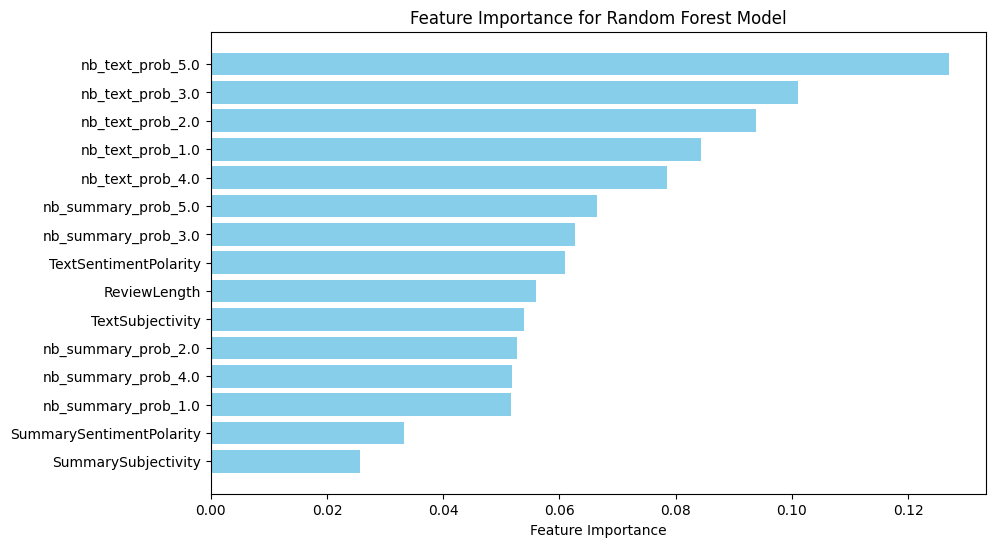

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance scores
feature_importances = rf_model.feature_importances_
features = X.columns

# Sort feature importances in descending order
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_features = features[sorted_idx]
sorted_importances = feature_importances[sorted_idx]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Random Forest Model')
plt.gca().invert_yaxis()
plt.show()


In [37]:
from sklearn.metrics import classification_report

print("Detailed Classification Report:")
print(classification_report(y_test, y_pred))


Detailed Classification Report:
              precision    recall  f1-score   support

         1.0       0.57      0.57      0.57      3684
         2.0       0.40      0.25      0.30      3622
         3.0       0.46      0.37      0.41      7113
         4.0       0.48      0.36      0.41     13541
         5.0       0.74      0.88      0.81     32040

    accuracy                           0.65     60000
   macro avg       0.53      0.48      0.50     60000
weighted avg       0.62      0.65      0.62     60000



60000


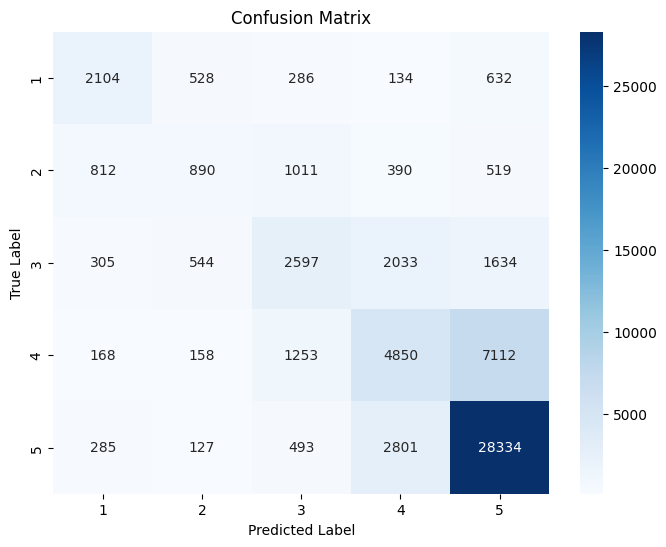

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(y_test.size)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

FOR TEST SUBMISSION (TRAINING AND USING MODEL ON THE TEST SET)

In [39]:
import pandas as pd
from textblob import TextBlob


# Step 1: Filter and merge to align `matching_data` with `testingSet`
matching_data = trainingSet2[trainingSet2['Id'].isin(testingSet['Id'])].copy()
print(matching_data.head())
print(matching_data.shape)

matching_data['ReviewLength'] = matching_data['Text'].apply(lambda x: len(x) if isinstance(x, str) else 0)

# Calculate `TextSubjectivity` and `TextSentimentPolarity`
matching_data['TextSubjectivity'] = matching_data['Text'].apply(
    lambda text: TextBlob(text).sentiment.subjectivity if isinstance(text, str) else 0
)
matching_data['TextSentimentPolarity'] = matching_data['Text'].apply(
    lambda text: TextBlob(text).sentiment.polarity if isinstance(text, str) else 0
)

# Calculate `SummarySubjectivity` and `SummarySentimentPolarity`
matching_data['SummarySubjectivity'] = matching_data['Summary'].apply(
    lambda summary: TextBlob(summary).sentiment.subjectivity if isinstance(summary, str) else 0
)
matching_data['SummarySentimentPolarity'] = matching_data['Summary'].apply(
    lambda summary: TextBlob(summary).sentiment.polarity if isinstance(summary, str) else 0
)

matching_data.head()


              Id   ProductId          UserId  HelpfulnessNumerator  \
1485341  1323432  B0034G4P30  A120UTHQDQIJGH                     0   
1485342  1137299  B0012IWO0I  A3SJBFCTJWBFT2                     1   
1485343  1459366  B005FUTBSC  A1V6FRU7EXP6N9                     0   
1485344   931601  B000AREXBU   ARXDDR76Z5Q2I                     5   
1485345  1311995  B002ZG99B8   A2XAS9GVZL3B1                     2   

         HelpfulnessDenominator        Time  \
1485341                       0  1391040000   
1485342                       1  1388188800   
1485343                       0  1356739200   
1485344                       5  1169510400   
1485345                       2  1392595200   

                                                   Summary  \
1485341                                  Okay for a rental   
1485342                                     Great for kids   
1485343                                         good movie   
1485344  Excellent quality dvd.  Don't pay big b

,Id,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,Score,ReviewLength,TextSubjectivity,TextSentimentPolarity,SummarySubjectivity,SummarySentimentPolarity
1485341,1323432,B0034G4P30,A120UTHQDQIJGH,0,0,1391040000,Okay for a rental,This movie was just alright for me. I think pe...,NaN,836,0.500744,0.322768,0.50,0.5
1485342,1137299,B0012IWO0I,A3SJBFCTJWBFT2,1,1,1388188800,Great for kids,My kids love this movie. Exciting and fun to ...,NaN,106,0.525000,0.400000,0.75,0.8
1485343,1459366,B005FUTBSC,A1V6FRU7EXP6N9,0,0,1356739200,good movie,"The effects were good, not the best but far fr...",NaN,126,0.740000,0.280000,0.60,0.7
1485344,931601,B000AREXBU,ARXDDR76Z5Q2I,5,5,1169510400,Excellent quality dvd. Don't pay big bucks fo...,"I just got a copy of this S. Korean dvd of ""He...",NaN,445,0.582222,0.526111,0.55,0.5
1485345,1311995,B002ZG99B8,A2XAS9GVZL3B1,2,2,1392595200,A mixed review,"OK, to put this clearly and bluntly... if you ...",NaN,551,0.419643,0.092262,0.25,0.0


In [40]:
# FITTING NAIVE BAYES TO THE TEST DATA AND ADDING ITS FEATURES

matching_data['Text'] = matching_data['Text'].fillna("")
matching_data['Summary'] = matching_data['Summary'].fillna("")

class_names = [1.0, 2.0, 3.0, 4.0, 5.0]
# Step 1: Initialize columns in feature_df for storing probabilities for each class
# Step 1: Initialize columns in feature_df for storing probabilities for each class
for class_name in class_names:
    matching_data[f'nb_text_prob_{class_name}'] = 0  # Initialize with zeroes
    matching_data[f'nb_summary_prob_{class_name}'] = 0  # For summary probabilities

# Step 2: Loop through each class and add predictions as features in feature_df
for i, class_name in enumerate(class_names):
    # Create binary target for the current class
    train_target = (samples[1]['Score'] == class_name).astype(int)

    # Fit text and summary pipelines on binary target for this class
    text_pipeline.fit(samples[1]['Text'].values, train_target)
    summary_pipeline.fit(samples[1]['Summary'].values, train_target)

    # Get probabilities for `samples[0]` for each class
    text_probs = text_pipeline.predict_proba(matching_data['Text'].values)[:, 1]  # Probability of being in `class_name`
    summary_probs = summary_pipeline.predict_proba(matching_data['Summary'].values)[:, 1]

    # Add these probabilities to `feature_df`
    matching_data[f'nb_text_prob_{class_name}'] = text_probs
    matching_data[f'nb_summary_prob_{class_name}'] = summary_probs



# Final DataFrame: test_feature_df contains features and predicted scores for each ID in testingSet
print(matching_data.head())
print("Size of DataFrame:", matching_data.shape)


              Id   ProductId          UserId  HelpfulnessNumerator  \
1485341  1323432  B0034G4P30  A120UTHQDQIJGH                     0   
1485342  1137299  B0012IWO0I  A3SJBFCTJWBFT2                     1   
1485343  1459366  B005FUTBSC  A1V6FRU7EXP6N9                     0   
1485344   931601  B000AREXBU   ARXDDR76Z5Q2I                     5   
1485345  1311995  B002ZG99B8   A2XAS9GVZL3B1                     2   

         HelpfulnessDenominator        Time  \
1485341                       0  1391040000   
1485342                       1  1388188800   
1485343                       0  1356739200   
1485344                       5  1169510400   
1485345                       2  1392595200   

                                                   Summary  \
1485341                                  Okay for a rental   
1485342                                     Great for kids   
1485343                                         good movie   
1485344  Excellent quality dvd.  Don't pay big b

In [41]:
#PREDICTING SCORES ON THE TEST SUBMISSION


columns_to_drop = ["Id", "ProductId", "UserId", "HelpfulnessNumerator", "HelpfulnessDenominator", "Time", "Summary", "Text", "Score"]
matching_data_for_prediction = matching_data.drop(columns=columns_to_drop, errors='ignore')
required_columns = X_train.columns

# Reorder matching_data_for_prediction to match the order of columns in X_train
matching_data_for_prediction = matching_data_for_prediction[required_columns]


# Step 2: Predict Score on matching_data using the trained Random Forest model
predicted_scores = rf_model.predict(matching_data_for_prediction)

# Add predictions to matching_data as a new column
matching_data['Score'] = predicted_scores

# Display the DataFrame with predictions
print(matching_data.head())


              Id   ProductId          UserId  HelpfulnessNumerator  \
1485341  1323432  B0034G4P30  A120UTHQDQIJGH                     0   
1485342  1137299  B0012IWO0I  A3SJBFCTJWBFT2                     1   
1485343  1459366  B005FUTBSC  A1V6FRU7EXP6N9                     0   
1485344   931601  B000AREXBU   ARXDDR76Z5Q2I                     5   
1485345  1311995  B002ZG99B8   A2XAS9GVZL3B1                     2   

         HelpfulnessDenominator        Time  \
1485341                       0  1391040000   
1485342                       1  1388188800   
1485343                       0  1356739200   
1485344                       5  1169510400   
1485345                       2  1392595200   

                                                   Summary  \
1485341                                  Okay for a rental   
1485342                                     Great for kids   
1485343                                         good movie   
1485344  Excellent quality dvd.  Don't pay big b

In [42]:
#SAVING THE CORRECT CSV
from google.colab import files
prediction_df = matching_data[['Id', 'Score']]
prediction_df.to_csv("predicted_scores.csv", index=False)

# Download the file to your local machine
files.download("predicted_scores.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>